In [2]:
import os
import datetime
from src import CompanyDetails, FindValues, Analyse,PredictValues, SharePricePrediction
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Input
from keras.optimizers import Adam

In [3]:
c_list = ['RELIANCE','HDFCBANK','ICICIBANK', 'INFY']
c_share_price_df_dict = {}
for c in c_list:
    c_details = CompanyDetails(c)
    c_share_price_df = c_details.sharePriceRange('25y')
    c_share_price_df['Date'] = c_share_price_df['Date'].apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d')).sort_index()
    c_share_price_df.index = c_share_price_df.pop('Date')
    c_share_price_df_dict[c] = c_share_price_df
    print(f'{c} details added to dict')


RELIANCE details added to dict
HDFCBANK details added to dict
ICICIBANK details added to dict
INFY details added to dict


In [4]:
print(c_share_price_df_dict)

{'RELIANCE':               Close       ema100       ema200
Date                                         
2000-03-28    13.61    13.610000    13.610000
2000-03-29    13.15    13.600891    13.605423
2000-03-30    14.20    13.612755    13.611339
2000-03-31    15.34    13.646958    13.628540
2000-04-03    15.93    13.692166    13.651440
...             ...          ...          ...
2025-03-24  1302.10  1272.514330  1311.843345
2025-03-25  1285.45  1272.770482  1311.580725
2025-03-26  1273.05  1272.776017  1311.197335
2025-03-27  1278.20  1272.883422  1310.869003
2025-03-28  1275.10  1272.927315  1310.513093

[6237 rows x 3 columns], 'HDFCBANK':               Close       ema100       ema200
Date                                         
2000-03-28    22.56    22.560000    22.560000
2000-03-29    21.76    22.544158    22.552040
2000-03-30    21.53    22.524076    22.541870
2000-03-31    21.09    22.495679    22.527424
2000-04-03    20.27    22.451606    22.504962
...             ...          

dict_keys(['RELIANCE', 'HDFCBANK', 'ICICIBANK', 'INFY'])


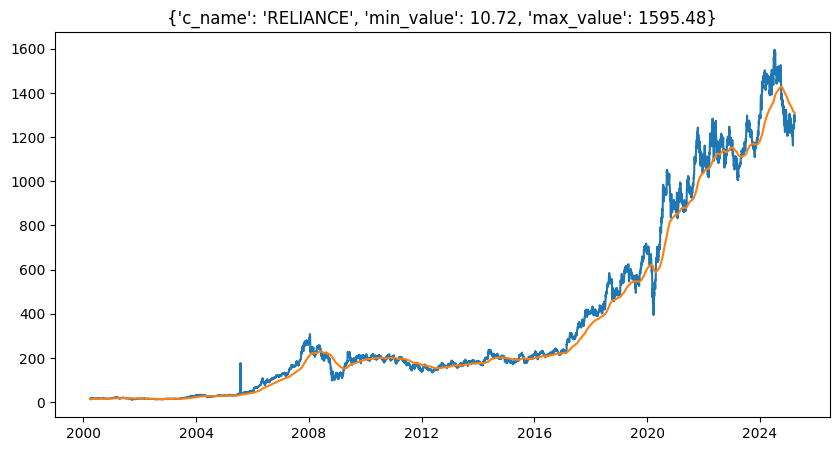

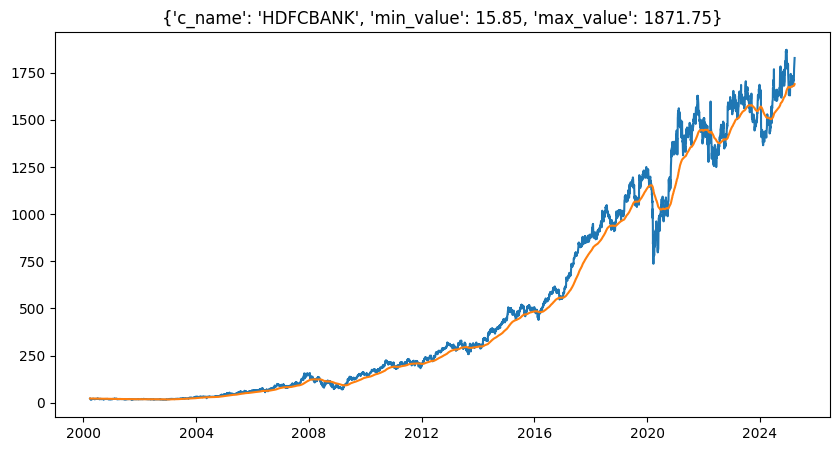

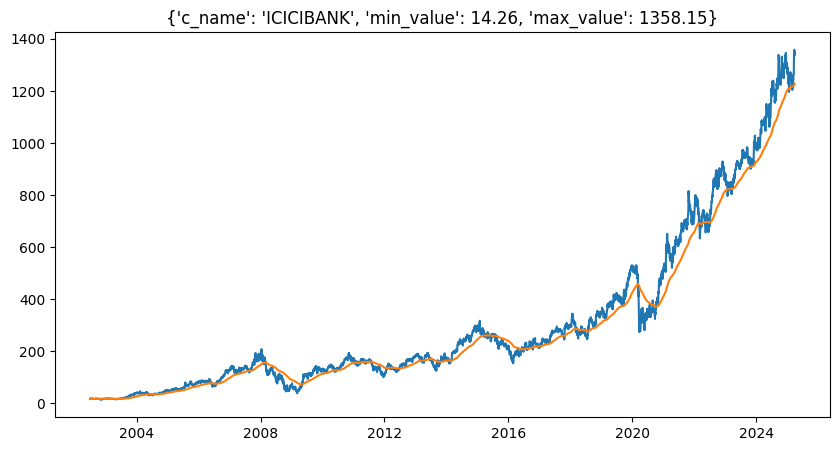

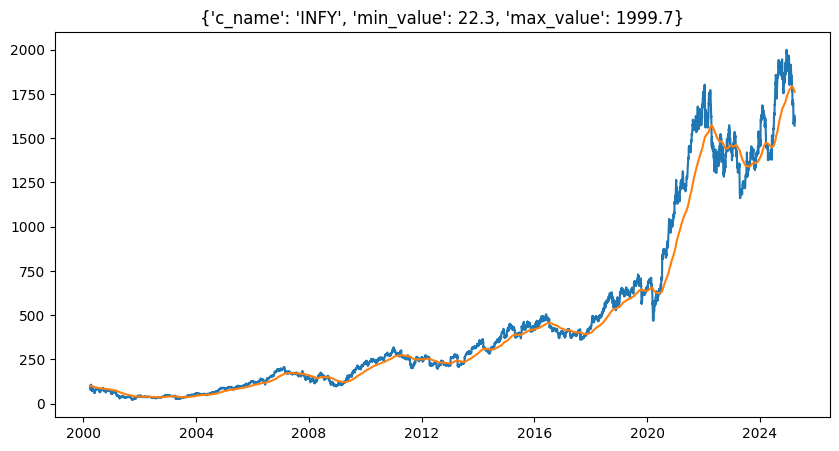

In [6]:
print(c_share_price_df_dict.keys())
for c_name in c_share_price_df_dict.keys():
    val = ({
            'c_name':c_name, 
            'min_value': min(c_share_price_df_dict[c_name]['Close']), 
            'max_value' : max(c_share_price_df_dict[c_name]['Close'])
        })
    plt.figure(figsize=(10, 5))
    plt.title(val)
    plt.plot(c_share_price_df_dict[c_name].index, c_share_price_df_dict[c_name]['Close'])
    plt.plot(c_share_price_df_dict[c_name].index, c_share_price_df_dict[c_name]['ema200'])

In [ ]:
def train_model(x_data, y_data):
    """
    Build, compile, and train an LSTM model on the combined dataset.
    Returns the trained model.
    """
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.regularizers import l2

    # Split into train (80%), val (10%), test (10%)
    num_samples = len(x_data)
    train_end = int(num_samples * 0.8)
    val_end   = int(num_samples * 0.9)
    
    x_train, y_train = x_data[:train_end], y_data[:train_end]
    x_val,   y_val   = x_data[train_end:val_end], y_data[train_end:val_end]
    x_test,  y_test  = x_data[val_end:], y_data[val_end:]
    
    # Build the model
    model = Sequential()
    model.add(LSTM(units=120, activation='relu', return_sequences=True,
                   input_shape=(x_data.shape[1], x_data.shape[2]),
                   kernel_regularizer=l2(0.01),
                   recurrent_dropout=0.2))
    model.add(LSTM(units=64, activation='relu', return_sequences=True,
                   kernel_regularizer=l2(0.01),
                   recurrent_dropout=0.2))
    model.add(LSTM(units=32, activation='relu', return_sequences=False,
                   kernel_regularizer=l2(0.01),
                   recurrent_dropout=0.2))
    
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    
    # Final output layer
    model.add(Dense(1, activation='linear'))
    
    model.compile(
        loss='mse',
        optimizer=Adam(learning_rate=0.001),
        metrics=['mae']
    )
    
    model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=200,
        batch_size=32
    )
    
    test_loss, test_mae = model.evaluate(x_test, y_test)
    print(f"Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")
    
    return model
